# MNIST

### MNIST 데이터 받기

In [2]:
import os
import sys
# from six.moves import urllib0
import gzip
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
FILENAME = SOURCE_URL.split('/')[-1]
DATA_DIR = './datasets'

def maybe_download(data_dir):
    filepath = os.path.join(data_dir, FILENAME)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.isfile(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
                FILENAME, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')

def load(data_dir, subset='train'):
    maybe_download(data_dir)
    filepath = os.path.join(data_dir, FILENAME)
    
    f = gzip.open(filepath, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()
    f.close()
    
    if subset == 'train':
        trainx, trainy = train_set
        trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
        trainy = trainy.astype(np.uint8)
        return trainx, trainy
    elif subset == 'test':
        testx, testy = test_set
        testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
        testy = testy.astype(np.uint8)
        return testx, testy
    elif subset== 'valid':
        validx, validy = valid_set
        validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
        validy = validy.astype(np.uint8)
        return validx, validy
    else:
        raise NotImplementedError('subset should be train or valid or test')

# Load data
train_data, train_label = load(DATA_DIR, 'train')
valid_data, valid_label = load(DATA_DIR, 'valid')
test_data, test_label = load(DATA_DIR, 'test')

# concatenate train and valid data as train data
train_data = np.concatenate((train_data, valid_data))
train_label = np.concatenate((train_label, valid_label))

### MNIST 데이터 확인 하기

In [3]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


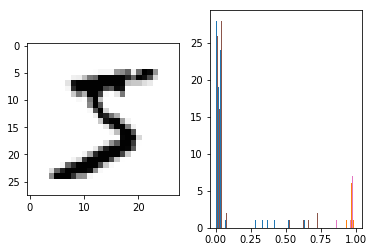

In [4]:
# show data
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[0]
ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax2.hist(sample_data, bins=20, range=[0, 1]);

### =================================================================

In [5]:
import tensorflow as tf

In [6]:
def model(X,by):
    X = tf.expand_dims(X, axis = 3)
    with tf.variable_scope('first'):
        outs = tf.layers.conv2d(X, 128, 3, padding = 'same') #filter : 128, kernel : 3
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2) #stride : 2, size : 2
    with tf.variable_scope('second'):
        outs = tf.layers.conv2d(outs,256,3, padding = 'same')
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2)
    with tf.variable_scope('third'):
        outs = tf.layers.conv2d(outs, 128, 3, padding = 'same')
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2)
    outs = tf.reshape(outs, (-1, outs.shape[1]*outs.shape[2]*outs.shape[3]))
    #fully connected layer 
    outs = tf.layers.dense(outs, 256)
    outs = tf.nn.relu(outs)
    outs = tf.layers.dense(outs, 10)
    #cross entropy
    one_hot = tf.one_hot(by,10)
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = one_hot, logits = outs)

    #optimizer
    loss = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
    preds = tf.cast(tf.argmax(tf.nn.softmax(outs), axis = 1),tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(by, preds), tf.float32)) #label, prediction
    
    return {
        'loss' : loss, 'opt' : opt, 'preds' : preds, 'acc' : acc
    }

In [7]:
X = tf.placeholder(tf.float32, shape = (None, 28,28))
by = tf.placeholder(tf.int32)

ours = model(X,by)
init = tf.global_variables_initializer()

In [8]:
num_epochs = 100
batch_size = 100
num_display = 100
num_samples = 60000

In [12]:
with tf.Session() as sess:
    sess.run(init)
    for ind_epoch in range(0,num_epochs):
        print('Current iteration {}'.format(ind_epoch +1))
        for ind_ in range(0, int(num_samples/batch_size)) : 
            batch_X = train_data[ind_ * batch_size:(ind_+1)*batch_size]
            batch_by = train_label[ind_ * batch_size:(ind_+1)*batch_size]
            
            _, cur_loss, cur_acc = sess.run([ours['opt'], ours['loss'], ours['acc']], feed_dict = {X:batch_X, by:batch_by})
#             if ind_% num_display == 0:
#                 print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
            _, cur_loss, cur_acc = sess.run([ours['opt'], ours['loss'], ours['acc']], feed_dict={X:test_data, by:test_label})
            print('Test3 loss :{0:.4f}, acc : {1:.4f}'.format(cur_loss, cur_acc))

Current iteration 1


ResourceExhaustedError: OOM when allocating tensor with shape[10000,128,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node first/conv2d/Conv2D (defined at <ipython-input-6-f8e414da0f75>:4)  = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients/first/conv2d/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, first/conv2d/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node Mean_1/_15}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_361_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'first/conv2d/Conv2D', defined at:
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-9c7e4bb2288a>", line 4, in <module>
    ours = model(X,by)
  File "<ipython-input-6-f8e414da0f75>", line 4, in model
    outs = tf.layers.conv2d(X, 128, 3, padding = 'same') #filter : 128, kernel : 3
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 417, in conv2d
    return layer.apply(inputs)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/keras/layers/convolutional.py", line 194, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 957, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,128,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node first/conv2d/Conv2D (defined at <ipython-input-6-f8e414da0f75>:4)  = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients/first/conv2d/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, first/conv2d/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node Mean_1/_15}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_361_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

